# IMPC Data Engineer - Technical Test (EBI02156)

Date: 8 October 2023

Time for completion: I spent about half a day on and off on this.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme() # set default seaborn theme

## Import data (Question 1)

In [2]:
df_red = pd.read_csv("data/winequality/winequality-red.csv", sep=';')
df_white = pd.read_csv("data/winequality/winequality-white.csv", sep=';')

# add information about the type of wine
df_red["wine_type"] = "red"
df_white["wine_type"] = "white"

# combine into a single dataframe
df_wine = pd.concat([df_red, df_white])
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [3]:
# check for missing values
if df_wine.isna().any().any():
    print("There are missing values in the DataFrame.")
else:
    print("There are no missing values in the DataFrame.")

There are no missing values in the DataFrame.


## Exploratory data analysis (Question 2)

### Quick tally

We start by doing a quick tally of the quality scores across the red and white wines.

In [4]:
values, counts = np.unique(df_red['quality'], return_counts=True)
frequency_table1 = pd.DataFrame({'Quality': values, 'Frequency': counts, 'WineType': 'red'})

values, counts = np.unique(df_white['quality'], return_counts=True)
frequency_table2 = pd.DataFrame({'Quality': values, 'Frequency': counts, 'WineType': 'white'})

(
    pd.concat([frequency_table1, frequency_table2])
    .pivot(index='WineType', columns = 'Quality', values = 'Frequency')
    .fillna(0)
    .astype(int)
)

Quality,3,4,5,6,7,8,9
WineType,,,,,,,
red,10,53,681,638,199,18,0
white,20,163,1457,2198,880,175,5


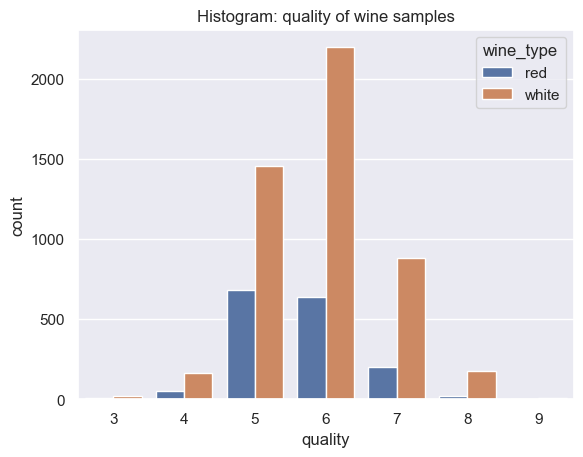

In [5]:
sns.countplot(df_wine, x='quality', hue='wine_type')
plt.title('Histogram: quality of wine samples')
plt.savefig(f'output/q2-EDA_counts.pdf')

We observe that there are more white wines in this dataset than red wines (4898 vs 1599), although the distribution of the quality scores is quite similar. 

The quality scores are also all integers, hence are not strictly continuous variables.

There is also some imbalance in the data: there are 5 white wines that **scored a 9**, but **no red wines** got this score.

### Physiochemical tests

There are eleven different physiochemical measurements for each wine sample.

In [6]:
df_wine.drop(['quality', 'wine_type'], axis=1).columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In this section, I will create some scatterplots and histograms to illustrate the distribution of physiochemical measurements for the wine samples. For this, I will convert the dataframe into a long format.

In [7]:
df_wine_long = pd.melt(df_wine, id_vars=["quality", "wine_type"])
df_wine_long.head()

,quality,wine_type,variable,value
0,5,red,fixed acidity,7.4
1,5,red,fixed acidity,7.8
2,5,red,fixed acidity,7.8
3,6,red,fixed acidity,11.2
4,5,red,fixed acidity,7.4


Scatterplots for physiochemical measurements agaisnt quality scores, with a line of best fit for each variable. Some variables show a noticeable correlation with the score quality, such as alcohol (positive correlation) and density (negative). Others don't seem to have any, like the pH.

/Users/pittachalk/.software/miniconda3_x86/envs/ebi02156/lib/python3.11/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/pittachalk/.software/miniconda3_x86/envs/ebi02156/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/n9/wzxyrj1177g3sl3njh4vxpdh0000gp/T/ipykernel_17757/1451761392.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


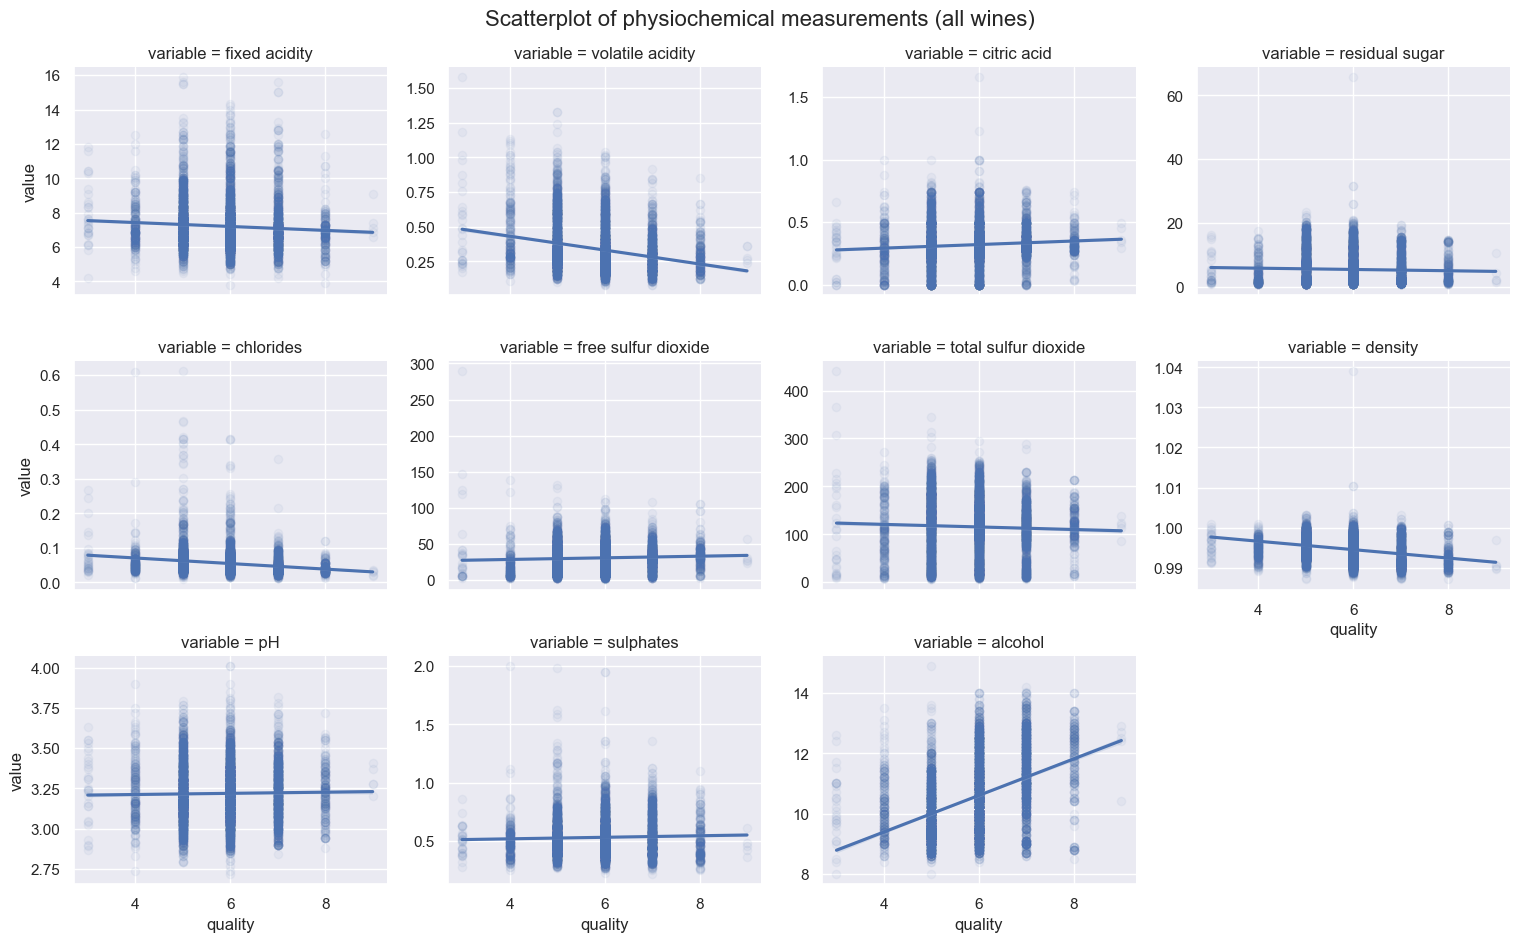

In [8]:
sns.lmplot(
    data = df_wine_long, 
    x = 'quality', y = 'value',
    scatter_kws = {"alpha": 0.05}, # modify transparency of points to reduce overplotting
    col = 'variable', col_wrap=4, sharey=False,
    height=3.2, aspect=1.2
)
plt.suptitle("Scatterplot of physiochemical measurements (all wines)", fontsize=16)
plt.tight_layout()
plt.savefig('output/q2-EDA_scatter_numeric_all.pdf')

Next, we make the same plot, but with the different lines of best fit for the two wine types. We see that certain variables still maintain a similar correlation pattern (e.g. alcohol). However, we see that there might be some measurements that have finer-scale correlation signals within wine types that gets "blurred out" or "weakened" when looked as a whole, for example total sulfur dioxide.

/Users/pittachalk/.software/miniconda3_x86/envs/ebi02156/lib/python3.11/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/pittachalk/.software/miniconda3_x86/envs/ebi02156/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/n9/wzxyrj1177g3sl3njh4vxpdh0000gp/T/ipykernel_17757/746008739.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


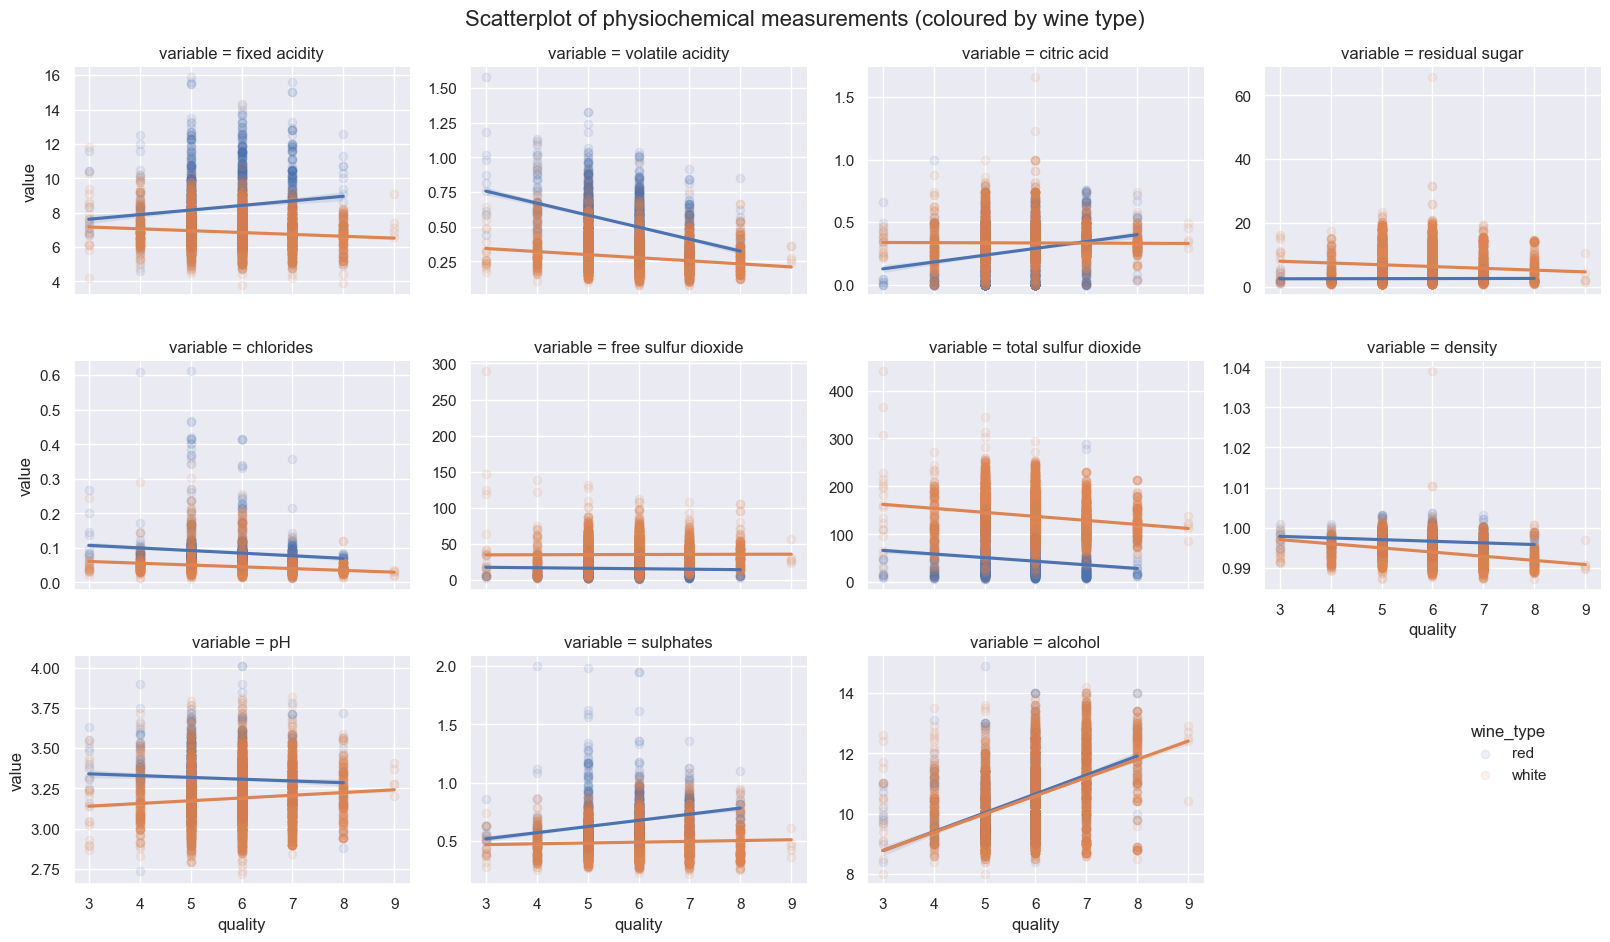

In [9]:
g = sns.lmplot(
    data = df_wine_long, 
    x = 'quality', y = 'value', hue = 'wine_type',
    scatter_kws = {"alpha": 0.1}, # modify transparency of points to reduce overplotting
    col='variable', col_wrap=4, sharey=False,
    height=3.2, aspect=1.2
)
sns.move_legend(g, "upper left", bbox_to_anchor=(.9, .25), frameon=False)
plt.suptitle("Scatterplot of physiochemical measurements (coloured by wine type)", fontsize=16)
plt.tight_layout()
plt.savefig('output/q2-EDA_scatter_numeric_bytype.pdf')

Below are the histograms showing the distribution of the physiochemical measurements coloured by wine type.

/Users/pittachalk/.software/miniconda3_x86/envs/ebi02156/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/n9/wzxyrj1177g3sl3njh4vxpdh0000gp/T/ipykernel_17757/754628713.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


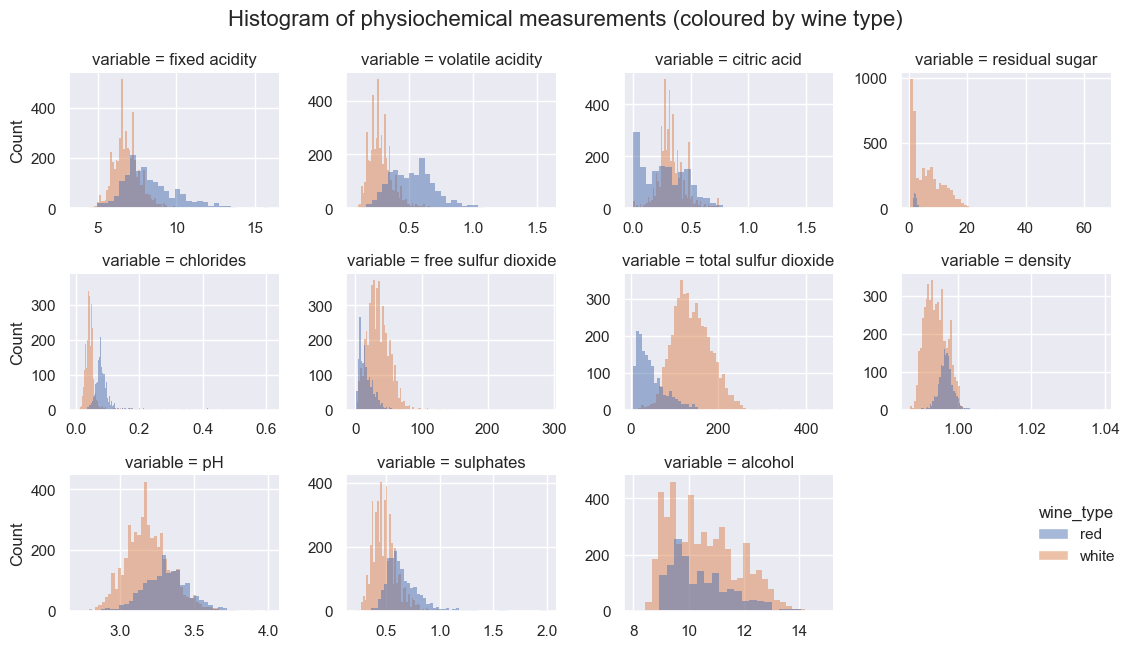

In [10]:
g = sns.displot(
    data = df_wine_long, 
    x = "value", hue = 'wine_type',
    col = 'variable', col_wrap=4,
    facet_kws = dict(sharex=False, sharey=False, legend_out=True),
    common_bins = False, height=2.2, aspect=1.2
)
g.set(xlabel=None)
sns.move_legend(g, "upper left", bbox_to_anchor=(.9, .25), frameon=False)
plt.suptitle("Histogram of physiochemical measurements (coloured by wine type)", fontsize=16)
plt.tight_layout()
plt.savefig('output/q2-EDA_histogram.pdf')

Just looking by eye across these plots, these seems to be slight degree of separation of the red and white wine types across some of the physiochemical measurements, such as volatile acidity and chlorides.

This suggests that they might need to be treated in separate linear regression models later on, just like how people would judge wines in real life.

Here are the **mean** values of the physiochemical measurements, calculated as a whole, and stratified by wine type.

In [11]:
pd.DataFrame({
    'Overall': df_wine.drop('wine_type', axis=1).mean(),
    'Red': df_red.drop('wine_type', axis=1).mean(),
    'White': df_white.drop('wine_type', axis=1).mean()
})

,Overall,Red,White
fixed acidity,7.215307,8.319637,6.854788
volatile acidity,0.339666,0.527821,0.278241
citric acid,0.318633,0.270976,0.334192
residual sugar,5.443235,2.538806,6.391415
chlorides,0.056034,0.087467,0.045772
free sulfur dioxide,30.525319,15.874922,35.308085
total sulfur dioxide,115.744574,46.467792,138.360657
density,0.994697,0.996747,0.994027
pH,3.218501,3.311113,3.188267
sulphates,0.531268,0.658149,0.489847


## Correlation matrix and heatmap (Questions 3 & 4)

First, I plot a correlation matrix of all the 11 physiochemical tests with both types of wine bundled together.

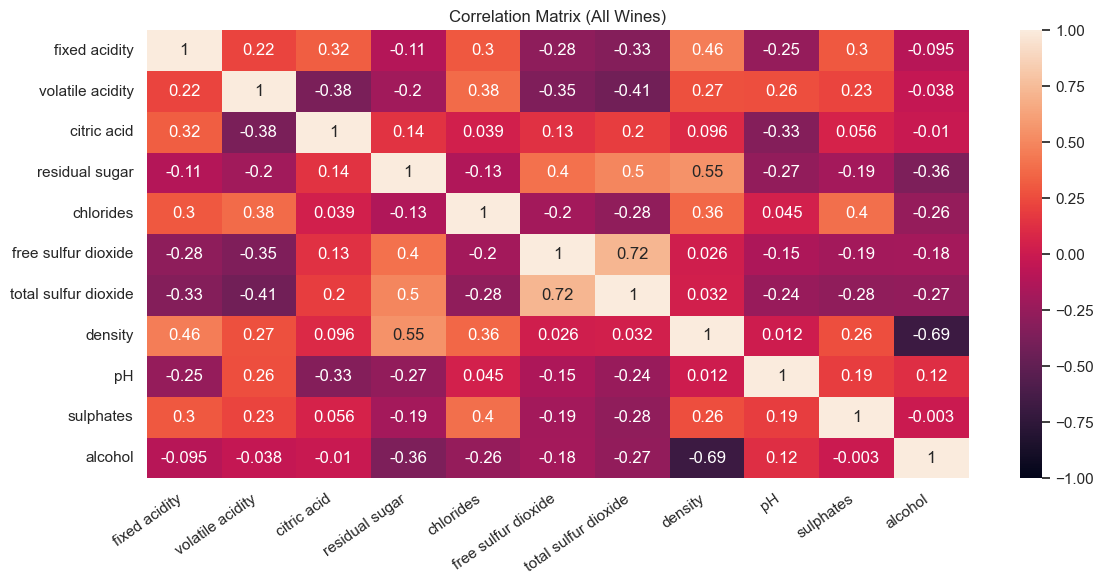

In [12]:
corr_matrix = df_wine.drop(['quality', 'wine_type'], axis=1).corr('pearson')

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)
plt.title("Correlation Matrix (All Wines)")
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.savefig('output/q4-correlation_all.pdf')

Next, I redo this plot, but for the two types of wines stratified.

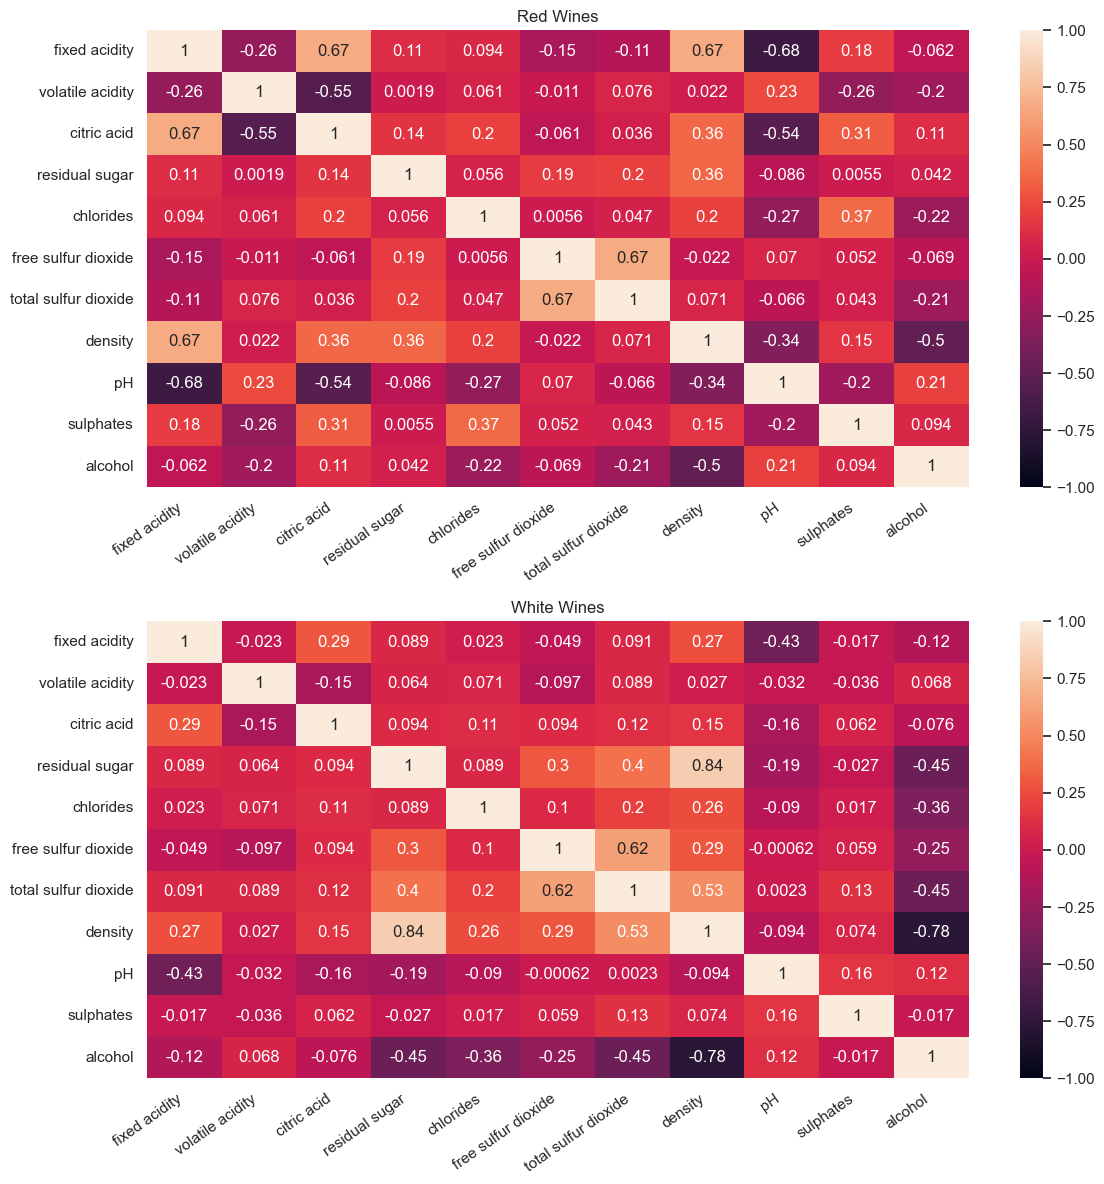

In [13]:
corr_matrix1 = df_red.drop(['quality', 'wine_type'], axis=1).corr('pearson')
corr_matrix2 = df_white.drop(['quality', 'wine_type'], axis=1).corr('pearson')

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
sns.heatmap(corr_matrix1, vmin=-1, vmax=1, annot=True)
plt.title("Red Wines")
plt.xticks(rotation=35, ha='right')

plt.subplot(2, 1, 2)
sns.heatmap(corr_matrix2, vmin=-1, vmax=1, annot=True)
plt.title("White Wines")
plt.xticks(rotation=35, ha='right')

plt.tight_layout()
plt.savefig('output/q4-correlation_bytype.pdf')

## Multiple linear regression analysis (Questions 5 & 6)

I will try three different approaches to perform multiple linear regression analysis to predict wine quality based on the other variables.

1. Ignore wine type completely.
2. Treat wine type as a categorical variable.
3. Fit separate models for red and white wines.

I will try these approaches and evaluate which perform the best in three things:
* **R-squared** (higher is better).
* **Mean squared error** and **mean absolute error** of the fitted vs true values for the quality scores (lower is better).
* Analysis of **residuals** and **Cook's distance**.

Later, I will interpret the regression results for what I consider to be the best approach for this data.

Here are some functions written to fit multiple linear regression models and evaluate how good they are.

In [14]:
import statsmodels.api as sm
from sklearn import metrics

def multiple_linear_regression(X, Y):
    """
    Fit multiple linear regression model.
    """
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    return(model)

def evaluate_model_performance(model):
    """
    Print R-squared, mean squared error and mean absolute error.
    """
    # R-squared value
    print(f"R-squared: {model.rsquared:.3f}")

    # errors of fitted values from true values
    mean_squared_error = metrics.mean_squared_error(Y, model.fittedvalues)
    print(f'mean_squared_error : {mean_squared_error:.3f}') 
    
    mean_absolute_error = metrics.mean_absolute_error(Y, model.fittedvalues)
    print(f'mean_absolute_error : {mean_absolute_error:.3f}') 

def evaluate_residuals(model, Y):
    """
    Make diagnostic plots to see the quality of the model based on residuals and Cook's distance.
    """
    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    # residual vs fitted values
    axs[0].scatter(model.fittedvalues, model.resid, c=Y, alpha=0.2, edgecolors='black')
    axs[0].axhline(y=0, color='red', linestyle='--')
    axs[0].set_xlabel('Fitted values')
    axs[0].set_ylabel('Residuals')

    # cook's distance
    cooks = model.get_influence().cooks_distance[0]
    axs[1].stem(range(len(cooks)), cooks)
    axs[1].set_xlabel('Observation number')
    axs[1].set_ylabel("Cook's distance")

    plt.tight_layout()
    return fig

### First approach: ignore wine type completely

R-squared: 0.292
mean_squared_error : 0.540
mean_absolute_error : 0.568


/var/folders/n9/wzxyrj1177g3sl3njh4vxpdh0000gp/T/ipykernel_17757/2063503392.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


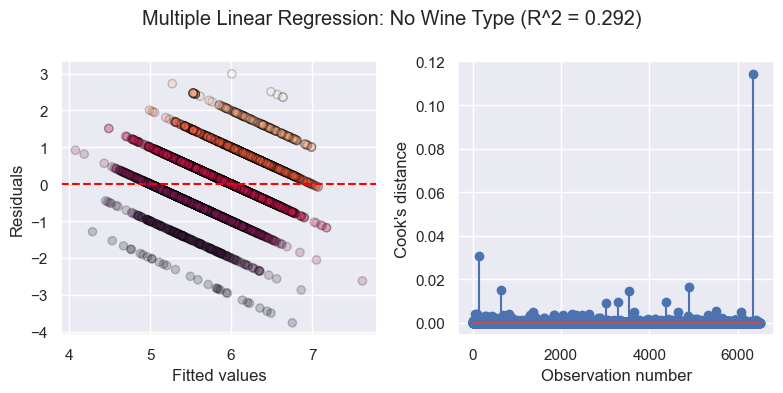

In [15]:
# model where wine type is ignored
X = df_wine.drop(['quality', 'wine_type'], axis = 1)
Y = df_wine['quality']
model_notype =  multiple_linear_regression(X, Y)
evaluate_model_performance(model_notype)
_ = evaluate_residuals(model_notype, Y)
plt.suptitle(f"Multiple Linear Regression: No Wine Type (R^2 = {model_notype.rsquared:.3f})")
plt.tight_layout()
plt.savefig(f'output/q5-model_notype.pdf')

The **R-squared** is a goodness of fit measure. The value of 0.292 suggests that 29.2% of the proportion of the variance in the dependent variable (quality score) can be explained by the independent variables in this linear model.

When we plot the **residuals** vs their fitted values for each sample, we see that they show up as bands. This is expected because of the nature of the data. The true quality scores are integers, but the fitted values are continuous. The bottommost band corresponds to samples with score 3, and the uppermost one are those with 9.

**Cook's Distance** is to measure if any point has a unenecessarily large effect on the model fitting. A rule of thumb is everything should be below 0.5. This looks reasonable.

**Mean squared error** and **mean absolute error** are slightly over 0.5: might be because it is halfway between the integer quality scores.

### Second approach: treat wine type as a categorical variable

For this approach, I used one-hot encoding to convert the wine type into a binary variable. This results in two columns to represent the wine type (see the last two columns).

In [16]:
X = pd.get_dummies(df_wine.drop('quality', axis = 1), columns=['wine_type'])
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_red,wine_type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,1
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0,1


R-squared: 0.297
mean_squared_error : 0.536
mean_absolute_error : 0.569


/var/folders/n9/wzxyrj1177g3sl3njh4vxpdh0000gp/T/ipykernel_17757/3930205913.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


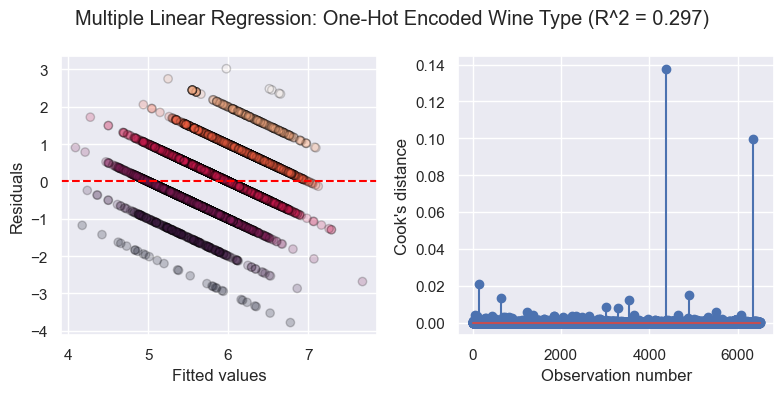

In [17]:
Y = df_wine['quality']
model_onehot =  multiple_linear_regression(X, Y)
evaluate_model_performance(model_onehot)
_ = evaluate_residuals(model_onehot, Y)
plt.suptitle(f"Multiple Linear Regression: One-Hot Encoded Wine Type (R^2 = {model_onehot.rsquared:.3f})")
plt.tight_layout()
plt.savefig(f'output/q5-model_onehot.pdf')

Overall, very similar performance to the first approach. Slightly better R-squared (0.297 vs 0.292), but nothing to write home about. I wouldn't say that incorporating the wine type as a categorical variable improves the prediction/fitting. 

### Third approach: run separate models for red and white wines

When fitting the multiple linear regression to the red wine samples alone, there is definitely an appreciable **improvement** in the goodness of fit, as signified by the **R-squared** of 0.361. We also see smaller mean squared and absolute errors.

R-squared: 0.361
mean_squared_error : 0.417
mean_absolute_error : 0.500


/var/folders/n9/wzxyrj1177g3sl3njh4vxpdh0000gp/T/ipykernel_17757/3102831948.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


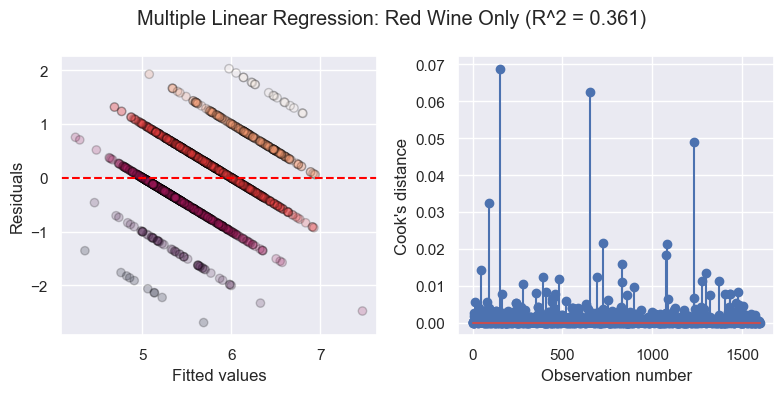

In [18]:
# model for red wine alone
X = df_red.drop(['quality', 'wine_type'], axis = 1)
Y = df_red['quality']
model_red =  multiple_linear_regression(X, Y)
evaluate_model_performance(model_red)
_ = evaluate_residuals(model_red, Y)
plt.suptitle(f"Multiple Linear Regression: Red Wine Only (R^2 = {model_red.rsquared:.3f})")
plt.tight_layout()
plt.savefig(f'output/q5-model_red.pdf')

Now, we repeat this analysis for the white wine samples:

R-squared: 0.282
mean_squared_error : 0.563
mean_absolute_error : 0.584


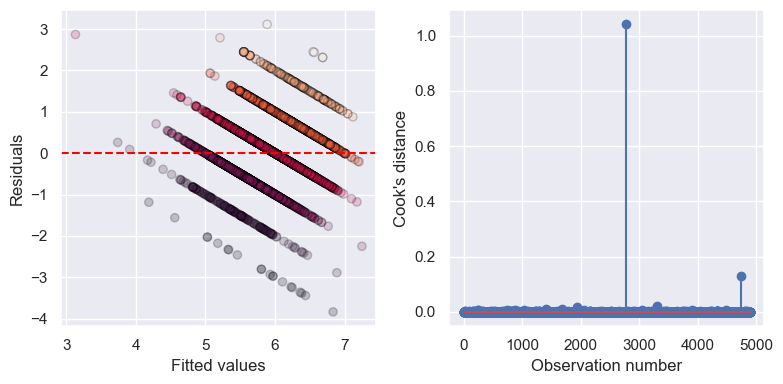

In [19]:
# model for white wine alone
X = df_white.drop(['quality', 'wine_type'], axis = 1)
Y = df_white['quality']
model_white =  multiple_linear_regression(X, Y)
evaluate_model_performance(model_white)
_ = evaluate_residuals(model_white, Y)

Because there is a strong effect of one of the samples on the model fitting(Cook's Distance > 0.5), we try to fit this model with that outlier removed.

R-squared: 0.285
mean_squared_error : 0.561
mean_absolute_error : 0.583


/var/folders/n9/wzxyrj1177g3sl3njh4vxpdh0000gp/T/ipykernel_17757/2997047270.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


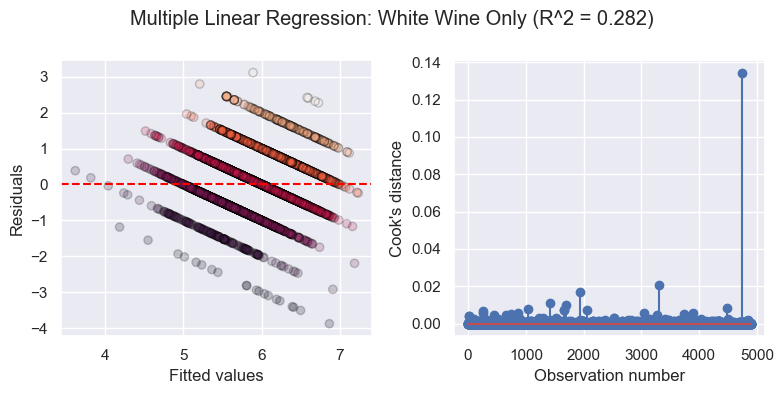

In [20]:
# model for white wine with the outlier removed
bool_filter = model_white.get_influence().cooks_distance[0] < 0.5
df_white_filt = df_white.loc[bool_filter]

X = df_white_filt.drop(['quality', 'wine_type'], axis = 1)
Y = df_white_filt['quality']
model_white_filt =  multiple_linear_regression(X, Y)
evaluate_model_performance(model_white_filt)
_ = evaluate_residuals(model_white_filt, Y)
plt.suptitle(f"Multiple Linear Regression: White Wine Only (R^2 = {model_white.rsquared:.3f})")
plt.tight_layout()
plt.savefig(f'output/q5-model_white.pdf')

Unfortunately, we do not see a similar improvement in the model fitting for the white wines with this approach.

### Coefficients and p-values

In [21]:
def obtain_coefficients_and_pvalues(model):
    """
    Print coefficient and p-values of a linear model.
    """
    # coefficients and intercept, as well as their p-values
    coef_pvalue_df = pd.DataFrame({'Coefficient': model.params, 'P-Value': model.pvalues})
    return coef_pvalue_df

Given the multiple linear regression model fitted on the red wine samples alone gave the best R-squared value, I will use it to discuss the coefficients and p-values:

In [22]:
obtain_coefficients_and_pvalues(model_red)

,Coefficient,P-Value
const,21.965208,3.001921e-01
fixed acidity,0.024991,3.356528e-01
volatile acidity,-1.083590,9.872361e-19
citric acid,-0.182564,2.149942e-01
residual sugar,0.016331,2.764960e-01
chlorides,-1.874225,8.373953e-06
free sulfur dioxide,0.004361,4.474495e-02
total sulfur dioxide,-0.003265,8.004610e-06
density,-17.881164,4.086079e-01
pH,-0.413653,3.100189e-02


**Coefficients** are the estimated impact of each independent variable on the dependent variable while the other variables remain constant. They indicate the direction (positve / negative) and magnitude of the relationship. 

These coefficients are associated with a **p-value** which tests the how likely that coefficient is equal to zero. A small p-value indicates that the variable is likely to have a significant effect on the dependent variable.

For example, in this model, volatile acidity is expected to be the most significant effect on quality score, with a coefficient of -1.084 and p-value of 9.87e-19. This can be interpreted that a decrease in the volatile acidity by 1.084 units would increase the score by 1 (assuming other variables are held constant).

The first row (`const`), also known as the **intercept** or **bias** term, is the predicted value of the dependent variable when all predictor variables (including the one-hot encoded variables) are zero. This value's purpose is primarily for the purposes of *model fitting*, but is **meaningless** here when talking about wines, as explained:

* pH of 0: drinking that will probably be life threatening.
* density of 0: density = mass / volume, so a value of 0 would be empty space.

Also note that the intercept value of 21.97 is not within the range of 0 to 10 for our wine scores.

#### Printing coefficients from other models (for reference)

In [23]:
obtain_coefficients_and_pvalues(model_notype)

,Coefficient,P-Value
const,55.762750,2.810512e-06
fixed acidity,0.067684,1.406093e-05
volatile acidity,-1.327892,1.336005e-64
citric acid,-0.109657,1.684750e-01
residual sugar,0.043559,3.603699e-17
chlorides,-0.483714,1.460010e-01
free sulfur dioxide,0.005970,2.224561e-15
total sulfur dioxide,-0.002481,3.859922e-19
density,-54.966942,6.041018e-06
pH,0.439296,1.195226e-06


## Recommendations and conclusions (Question 7)

Here is a summary of my findings / recommendations:

Fitting a multiple linear regression model to the wine datasets should give a reasonable prediction accuracy, as measured by the model errors on the training data.

Incorporating the wine type as a categorical variable, in addition to the 11 numeric physiochemical tests, did not seem to improve the goodness of fit. Based on Occam's razor, I would recommend the **simpler model**.

My recommendation is to **stratify** the samples by wine type for the regression analysis, which resulted in a better goodness of fit for the red wine samples.

Some predictors were more useful than others when it came to estimating scores, with the most useful ones being volatile acidity, sulfates and alcohol.

All the model struggle with the samples on both extremes of quality scores, with those having much higher model residuals. This is most likely because they are underrepresented in the training data. At the moment, all the models tend to give fitted values concentrated around 5 and 7. I recommend **collecting more data** for these extremes.

I also recommend devising a **continuous scoring system** for wine quality, because multiple linear regression is typically used for normally distributed, continuous numerical output variables. It might be slightly tricky in this scenario, because the quality scores may not reflect an ordinal relationship (i.e. a score from 2 to 3 may not reflect a same amount of improvement from 5 to 6). Perhaps taking the mean of the evaluations made by wine experts could be a good starting point?

Finally, I  emphasise that it is also worth doing **cross validation** on this multiple linear regression analysis to assess how well the models generalise to unseen data and detect potential overfitting.